This notebook performs Phase 1 of our project proposal. We use concatenated Morgan fingerprint vectors for each drug-drug pair as the input X-values for a Random Forest model.


Using drug-drug pairs obtained from the TWOSIDES database, selected for drug pairs that have kidney failure as a listed potential adverse effect, we perform initial investigation with a simple random forest model.
- Cleaned (salts and minor components removed) and unclean datasets both investigated
- For each the cleaned and uncleaned datasets, we investigate using the full-size dataset, which contains only 11% drug pairs that cause an adverse effect, and using random undersampling of the majority class to balance the dataset
- K-fold cross validation (k=5) and leave-one-out validation are performed
- After validation, a test dataset that was separated at the beginning will be used to assess performance
- Balanced accuracy, AUROC, and F1 score will be reported

###1. Setup

In [ ]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Installs
%%capture
!pip install --pre deepchem==2.5.0
!pip install rdkit==2022.3.4

In [ ]:
# Imports

import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import random

from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem

import deepchem as dc

import imblearn
from imblearn.under_sampling import RandomUnderSampler

####Load in data (csv files created from separate notebook and exported)



In [ ]:
# Load in train and test csv files
dirty_test_file = "/content/drive/MyDrive/BME 590 Colab files/dirty_test_ddi.csv"
dirty_train_file = "/content/drive/MyDrive/BME 590 Colab files/dirty_train_ddi.csv"

# Get smiles and interaction (0 or 1) from the dataframe
df_train = pd.read_csv(dirty_train_file)
df_train = df_train.iloc[:, [3, 5, 6]] #get smiles1, smiles2, and interaction classification (1 or 0)
df_train.head()

,Drug1,Drug2,Y
0,CN1CCC23C4C1CC5=C2C(=C(C=C5)O)OC3C(=O)CC4,CC(C)C1=C(C(=C(C(=N1)C(C)C)COC)C2=CC=C(C=C2)F)...,0
1,COC1=CC(=C(C=C1)OC)C(CNC(=O)CN)O,CC1=C(C(=CC=C1)NC2=CC=CC=C2C(=O)O)C,0
2,CCCCC1=NC2(CCCC2)C(=O)N1CC3=CC=C(C=C3)C4=CC=CC...,CC1=C(SC=N1)C=CC2=C(N3C(C(C3=O)NC(=O)C(=NOC)C4...,0
3,CN(CC(CO)O)C(=O)C1=C(C(=C(C(=C1I)C(=O)NCC(CO)O...,CN1CC(=O)N2C(C1=O)CC3=C(C2C4=CC5=C(C=C4)OCO5)N...,0
4,CC1=NN=C(S1)SCC2=C(N3C(C(C3=O)NC(=O)CN4C=NN=N4...,CNC(=O)C1=NC=CC(=C1)OC2=CC=C(C=C2)NC(=O)NC3=CC...,0


In [ ]:
# Quick look at dataframe
y = df_train.Y
l = len(df_train)
actives = np.sum(y)

print("Dataframe length (uncleaned data):", l)
print("Number of drug pairs with DDIs",actives, "\t",actives/l*100, "% of dataframe")
print("Number of non-DDI drug pairs", l - actives, "\t",(l-actives)/l*100, "% of dataframe")

Dataframe length (uncleaned data): 138532
Number of drug pairs with DDIs 15134 	 10.924551728120578 % of dataframe
Number of non-DDI drug pairs 123398 	 89.07544827187942 % of dataframe


In [ ]:
# Load in train and test csv files for clean data
clean_test_file = "/content/drive/MyDrive/BME 590 Colab files/clean_test_ddi.csv"
clean_train_file = "/content/drive/MyDrive/BME 590 Colab files/clean_train_ddi.csv"

# Get smiles and interaction (0 or 1) from the dataframe
df_train_clean = pd.read_csv(clean_train_file)
df_train_clean = df_train_clean.iloc[:, [3, 5, 6]] # Get smiles1, smiles2, and interaction classification (1 or 0)
df_train_clean.head()

,Drug1,Drug2,Y
0,CC12CCC3C(C1CCC2(C#C)O)CCC4=CC5=C(CC34C)C=NO5,CCN1CCN(C(=O)C1=O)C(=O)NC(C2=CC=CC=C2)C(=O)NC3...,0
1,CC(C)C1=C(C(=C(C(=N1)C(C)C)COC)C2=CC=C(C=C2)F)...,C(N)(N)(Cl)Cl,0
2,[O-]S(=O)(=O)[O-],CNC(=O)C1=NC=CC(=C1)OC2=CC=C(C=C2)NC(=O)NC3=CC...,0
3,CC(=O)NC(CS)C(=O)O,C1=CC(=CC=C1COC(CN2C=CN=C2)C3=C(C=C(C=C3)Cl)Cl)Cl,0
4,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C...,CC#CCC(C)C(C=CC1C(CC2C1CC(=CCCCC(=O)O)C2)O)O,0


In [ ]:
# Quick look at dataframe
y_clean = df_train_clean.Y
l = len(df_train_clean)
actives = np.sum(y_clean)

print("Dataframe length:", l)
print("Number of drug pairs with DDIs",actives, "\t",actives/l*100, "% of dataframe")
print("Number of non-DDI drug pairs", l - actives, "\t",(l-actives)/l*100, "% of dataframe")

Dataframe length: 136188
Number of drug pairs with DDIs 14804 	 10.870267571298498 % of dataframe
Number of non-DDI drug pairs 121384 	 89.1297324287015 % of dataframe


In [ ]:
# Convert drug-drug pairs to concatentated morgan fingerprints

def morgan_concat(data): # input dataframe with columns "Drug1" and "Drug2", returns concatenated Morgan fingerprints
  r = 2
  d = 1024
  fps = []

  for ind in range(len(data)):
    # SMILES
    d1 = data['Drug1'][ind]
    d2 = data['Drug2'][ind]

    # fingerprints from rdkit mols
    fp1 = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(d1), r, nBits = d, useChirality = True)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(d2), r, nBits = d, useChirality = True)
    fps.append(fp1+fp2)

  return fps

In [ ]:
#perform random undersampling of non-DDI drug pairs to balance the dataset

#undersample = RandomUnderSampler(sampling_strategy='majority') #in majority sampling strategy, will undersmaple the majority class to be the same size as minority. We can play with other methods
#X_under_unclean, y_under_unclean = undersample.fit_resample(fps_unclean_train, y)

#print("Size of balanced dataset from undersampling",len(y_under_unclean))
#print("Number of DDI pairs",np.sum(y_under_unclean))

Size of balanced dataset from undersampling 30268
Number of DDI pairs 15134


###2. K-fold cross-validation

In [ ]:
def k_fold_validation(X, y, n_splits = 5, balance = False): #x is concatenated fingerprints, y is array of 0s and 1s

  # define k-fold split
  kFold=KFold(n_splits = n_splits, random_state = 42, shuffle = True)

  # initialize arrays to store predictions and metrics
  predictions = np.array([])
  true_values = np.array([])
  acc = []
  bal_acc = []
  auroc = []
  f1 = []
  precision = []
  recall = []

  k_count = 0

  for train_index,test_index in kFold.split(X):
    print(k_count)
    k_count+=1

    y_train, y_test = y[train_index], y[test_index]
    X_train = [X[index] for index in train_index]
    X_test = [X[index] for index in test_index]

    if balance == True: #balance the training set (not the test/validation set)
        # Initialize undersampler
        undersample = RandomUnderSampler(sampling_strategy = 'majority')
        X_train, y_train = undersample.fit_resample(X_train, y_train)
        print("Size of training", len (X_train))

    #train random forest model
    model = RF()
    model.fit(X_train,y_train)

    #get predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    y_true = y_test

    #metrics
    acc.append(accuracy_score(y_true, y_pred))
    bal_acc.append(balanced_accuracy_score(y_true, y_pred))
    precision.append(precision_score(y_true, y_pred))
    recall.append(recall_score(y_true, y_pred))
    f1.append(f1_score(y_true, y_pred))
    auroc.append(roc_auc_score(y_true, y_prob[:,1]))

    print(bal_acc)
    print(f1)
    print(auroc)

    predictions = np.append(predictions, y_pred)
    true_values = np.append(true_values,y_true)

  return predictions, true_values, acc, bal_acc, precision, recall, f1, auroc

####2.1. Unclean dataset k-fold (k=5) cross validation

In [ ]:
# get fingerprints from full-length dirty training dataset
fps_unclean_train = morgan_concat(df_train)

Balanced

In [ ]:
# run the k_fold cross validation
# unclean_balanced_kfold = k_fold_validation(X_under_unclean, y_under_unclean)

unclean_balanced_kfold = k_fold_validation(fps_unclean_train, y, balance = True)

In [ ]:
predictions1, true_values1, acc1, bal_acc1, precision1, recall1, f1_1, auroc1= unclean_balanced_kfold

metrics = ["Accuracy", "Balanced Accuracy", "Precision", "Recall", "F1 score", "AUROC"]

print("Balanced, unclean data with k-fold (k=5) cross validation, averaged metrics \n")
for i in range(len(metrics)):
  print(metrics[i],":", np.mean(unclean_balanced_kfold[i+2]))


Balanced, unclean data with k-fold (k=5) cross validation, averaged metrics 

Accuracy : 0.7499206473148806
Balanced Accuracy : 0.7703518036956979
Precision : 0.27639189530625446
Recall : 0.7964807578757316
F1 score : 0.4103209126802671
AUROC : 0.8453943371942712


Unbalanced

In [ ]:
unclean_unbalanced_kfold = k_fold_validation(fps_unclean_train, y, balance = "False") #using whole dataset

0
[0.5306467824179913]
[0.12352772191898881]
[0.8271302871736368]
1
[0.5306467824179913, 0.5255286197149361]
[0.12352772191898881, 0.10780559646539029]
[0.8271302871736368, 0.8262729748944957]
2
[0.5306467824179913, 0.5255286197149361, 0.5259056073144637]
[0.12352772191898881, 0.10780559646539029, 0.1072644721906924]
[0.8271302871736368, 0.8262729748944957, 0.8318699295171234]
3
[0.5306467824179913, 0.5255286197149361, 0.5259056073144637, 0.5311492619957339]
[0.12352772191898881, 0.10780559646539029, 0.1072644721906924, 0.12463599301106582]
[0.8271302871736368, 0.8262729748944957, 0.8318699295171234, 0.8242645733501417]
4
[0.5306467824179913, 0.5255286197149361, 0.5259056073144637, 0.5311492619957339, 0.5285151942577082]
[0.12352772191898881, 0.10780559646539029, 0.1072644721906924, 0.12463599301106582, 0.11582568807339451]
[0.8271302871736368, 0.8262729748944957, 0.8318699295171234, 0.8242645733501417, 0.8279444477058281]


In [ ]:
predictions2, true_values2, acc2, bal_acc2, precision2, recall2, f1_2, auroc2= unclean_unbalanced_kfold

metrics = ["Accuracy", "Balanced Accuracy", "Precision", "Recall", "F1 score", "AUROC"]

print("Unbalanced, unclean data with k-fold (k=5) cross validation, averaged metrics \n")
for i in range(len(metrics)):
  print(metrics[i],":", np.mean(unclean_unbalanced_kfold[i+2]))

Unbalanced, unclean data with k-fold (k=5) cross validation, averaged metrics 

Accuracy : 0.889440694716891
Balanced Accuracy : 0.5283490931401666
Precision : 0.45944930647430426
Recall : 0.0662990000026496
F1 score : 0.11581189433190638
AUROC : 0.8274964425282452


####2.2 Clean dataset

In [ ]:
fps_clean_train = morgan_concat(df_train_clean) #get fingerprints from full-length clean training dataset

Balanced

In [ ]:
#run the k_fold cross validation
clean_balanced_kfold = k_fold_validation(fps_clean_train, y_clean, balance = True)

0
Size of training 23804
[0.78014980713385]
[0.4114483954900261]
[0.8477739116191377]
1
Size of training 23676
[0.78014980713385, 0.7761876692161793]
[0.4114483954900261, 0.4163464896961229]
[0.8477739116191377, 0.8499484767154537]
2
Size of training 23564
[0.78014980713385, 0.7761876692161793, 0.7776710466161922]
[0.4114483954900261, 0.4163464896961229, 0.4234925060996863]
[0.8477739116191377, 0.8499484767154537, 0.8527707121675929]
3
Size of training 23650
[0.78014980713385, 0.7761876692161793, 0.7776710466161922, 0.7759867344143774]
[0.4114483954900261, 0.4163464896961229, 0.4234925060996863, 0.4177956472336334]
[0.8477739116191377, 0.8499484767154537, 0.8527707121675929, 0.8504323943920412]
4
Size of training 23738
[0.78014980713385, 0.7761876692161793, 0.7776710466161922, 0.7759867344143774, 0.7798115900192313]
[0.4114483954900261, 0.4163464896961229, 0.4234925060996863, 0.4177956472336334, 0.4159400069759329]
[0.8477739116191377, 0.8499484767154537, 0.8527707121675929, 0.85043239

In [ ]:
predictions3, true_values3, acc3, bal_acc3, precision3, recall3, f1_3, auroc3= clean_balanced_kfold

metrics = ["Accuracy", "Balanced Accuracy", "Precision", "Recall", "F1 score", "AUROC"]

print("Balanced, clean data with k-fold (k=5) cross validation, averaged metrics \n")
for i in range(len(metrics)):
  print(metrics[i],":", np.mean(unclean_unbalanced_kfold[i+2]))

Balanced, clean data with k-fold (k=5) cross validation, averaged metrics 

Accuracy : 0.7531978443898992
Balanced Accuracy : 0.7742680518292048
Precision : 0.2800075415397974
Recall : 0.8012326118535003
F1 score : 0.41493966803298854
AUROC : 0.8473823826479997


Unbalanced

In [ ]:
clean_unbalanced_kfold = k_fold_validation(fps_clean_train, y_clean, balance = False) #using whole dataset

0
[0.5308984576598423]
[0.12391499551032624]
[0.8253168525435993]
1
[0.5308984576598423, 0.5264319922647842]
[0.12391499551032624, 0.10970215275729875]
[0.8253168525435993, 0.8253460388912176]
2
[0.5308984576598423, 0.5264319922647842, 0.5299759013135038]
[0.12391499551032624, 0.10970215275729875, 0.12154377880184333]
[0.8253168525435993, 0.8253460388912176, 0.8281001539858459]
3
[0.5308984576598423, 0.5264319922647842, 0.5299759013135038, 0.5252204876795662]
[0.12391499551032624, 0.10970215275729875, 0.12154377880184333, 0.10554245283018868]
[0.8253168525435993, 0.8253460388912176, 0.8281001539858459, 0.829039182707789]
4
[0.5308984576598423, 0.5264319922647842, 0.5299759013135038, 0.5252204876795662, 0.5268836476607459]
[0.12391499551032624, 0.10970215275729875, 0.12154377880184333, 0.10554245283018868, 0.1114734657574859]
[0.8253168525435993, 0.8253460388912176, 0.8281001539858459, 0.829039182707789, 0.8257092853596782]


In [ ]:
predictions5, true_values5, acc5, bal_acc5, precision5, recall5, f1_5, auroc5= clean_unbalanced_kfold

print("Unbalanced, clean data with k-fold (k=5) cross validation, averaged metrics \n")
for i in range(len(metrics)):
  print(metrics[i],":", np.mean(unclean_unbalanced_kfold[i+2]))

Unbalanced, clean data with k-fold (k=5) cross validation, averaged metrics 

Accuracy : 0.889440694716891
Balanced Accuracy : 0.5283490931401666
Precision : 0.45944930647430426
Recall : 0.0662990000026496
F1 score : 0.11581189433190638
AUROC : 0.8274964425282452


####2.3 Graph of comparison of training datasets on k-fold cross-validation

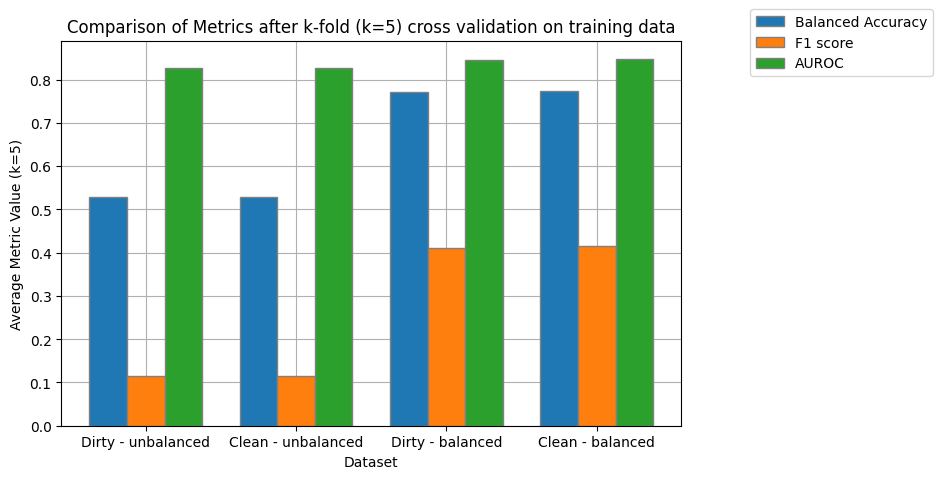

In [ ]:
#compare k-fold cross validation
import numpy as np
import scipy
import matplotlib.pyplot as plt

barWidth = 0.25
fig = plt.subplots(figsize =(8, 5))

#values here are the reported averages from metrics calculated from k-fold cross validation
#I just put the values in manually since I didn't run everything in the same session and so that you can see the plot without running all the code
bal_acc_all = [0.5283490931401666, 0.5283490931401666,0.7703518036956979,   0.7742680518292048]
f1_all = [0.11581189433190638,0.11581189433190638, 0.4103209126802671,   0.41493966803298854]
auroc_all = [0.8274964425282452, 0.8274964425282452,0.8453943371942712,  0.8473823826479997]

# Set position of bar on X axis
br1 = np.arange(len(bal_acc_all))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, bal_acc_all,  width = barWidth,
        edgecolor ='grey', label ='Balanced Accuracy')
plt.bar(br2, f1_all,  width = barWidth,
        edgecolor ='grey', label ='F1 score')
plt.bar(br3, auroc_all, width = barWidth,
        edgecolor ='grey', label ='AUROC')

plt.xlabel('Dataset')
plt.ylabel('Average Metric Value (k=5)')
plt.title('Comparison of Metrics after k-fold (k=5) cross validation on training data', fontsize = 12)
plt.xticks([r + barWidth for r in range(len(bal_acc_all))],
        ['Dirty - unbalanced', 'Clean - unbalanced', 'Dirty - balanced', 'Clean - balanced'])


plt.rcParams['axes.axisbelow'] = True
plt.grid(zorder = -1)
plt.legend(bbox_to_anchor = (1.1,1.1))
plt.show()

### 3. Leave-one-drug-out validation

In [ ]:
def leave_one_out(dataset, fingerprints, unique_drug_list, k_runs = 5, balance = False):
  dataframe = dataset
  fps = fingerprints
  unique_drugs = unique_drug_list

  predictions = np.array([])
  true_values = np.array([])
  acc = []
  bal_acc = []
  auroc = []
  f1 = []
  precision = []
  recall = []

  for k in range(0,k_runs): #5 loops through same as k-fold validation
    print(k)

    #randomly select a drug to be left out, then get all rows in dataframe that contain this drug to be validation data
    valid_drug = random.choice(unique_drugs)
    print(valid_drug)

    #create validation set from pairs containing selected drug
    validation_col1 = dataframe[dataframe["Drug1"].values == valid_drug]
    validation_col2 = dataframe[dataframe["Drug2"].values == valid_drug]
    validation = pd.concat([validation_col1, validation_col2], axis = 0)
    test_index = validation.index.values
    X_test = [fps[index] for index in test_index]
    y_test = y[test_index]

    train_index = dataframe.index.values
    train_index = [i for i in train_index if i not in test_index]
    X_train = [fps[index] for index in train_index]
    y_train = y[train_index]

    #create training dataset
    if balance == True:
      undersample = RandomUnderSampler(sampling_strategy = 'majority')
      X_train, y_train = undersample.fit_resample(X_train, y_train)

    print("size of training", len(train_index))
    print("size of testing", len(test_index))

    #train random forest model
    model = RF()
    model.fit(X_train,y_train)

    #get predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    y_true = y_test

    #metrics
    acc.append(accuracy_score(y_true, y_pred))
    bal_acc.append(balanced_accuracy_score(y_true, y_pred))
    precision.append(precision_score(y_true, y_pred))
    recall.append(recall_score(y_true, y_pred))
    f1.append(f1_score(y_true, y_pred))
    auroc.append(roc_auc_score(y_true, y_prob[:,1]))

    predictions = np.append(predictions, y_pred)
    true_values = np.append(true_values,y_true)

  return predictions, true_values, acc, bal_acc, auroc, f1, precision, recall

####3.1 Unclean dataset

In [ ]:
#get all possible drugs in the dataframe

X = df_train[["Drug1", "Drug2"]]
y = df_train.Y

firstcol_unique = X["Drug1"].unique()
secondcol_unique = X["Drug2"].unique()

all = np.concatenate([firstcol_unique,secondcol_unique])
unique_drugs = np.unique(all)
print("Number of unique drugs:",len(unique_drugs))

Number of unique drugs: 589


Unbalanced

In [ ]:
unclean_unbalanced_oneout = leave_one_out(df_train, fps_unclean_train, unique_drugs, k_runs=5, balance = False)

0
CC1=NN=C(S1)SCC2=C(N3C(C(C3=O)NC(=O)CN4C=NN=N4)SC2)C(=O)[O-]
size of training 138074
size of testing 458
1
C1CC(OC1CO)N2C=NC3=C2NC=NC3=O
size of training 138053
size of testing 479
2
CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)C(C(C5=CC=CC=C5)NC(=O)OC(C)(C)C)O)O)OC(=O)C6=CC=CC=C6)(CO4)OC(=O)C)O)C)O
size of training 138047
size of testing 485
3
CC(=O)C1CCC2C1(CCC3C2CCC4=CC(=O)CCC34C)C
size of training 138054
size of testing 478
4
CC1=C(C(C(=C(N1)C)C(=O)OC(C)C)C2=CC=CC3=NON=C32)C(=O)OC
size of training 138069
size of testing 463


In [ ]:
predictions, true_values, acc, bal_acc, precision, recall, f1_, auroc= unclean_unbalanced_oneout
metrics = ["Accuracy", "Balanced Accuracy", "Precision", "Recall", "F1 score", "AUROC"]

print("Unbalanced, unclean data with leave-one-out validation, averaged metrics \n")
for i in range(len(metrics)):
  print(metrics[i],":", np.mean(unclean_unbalanced_oneout[i+2]))


print(np.sum(predictions), "pairs predicted as interacting")
print(np.sum(true_values), "pairs actually interacting")

Unbalanced, unclean data with leave-one-out validation, averaged metrics 

Accuracy : 0.8629487844443602
Balanced Accuracy : 0.5253673956618762
Precision : 0.777967036417103
Recall : 0.10654983457402811
F1 score : 0.4062042124542124
AUROC : 0.08142697466467959
93.0 pairs predicted as interacting
283.0 pairs actually interacting


In [ ]:
#quick comparison of predicted positive and actual postive

loc_pred = np.where(predictions == 1)[0]
#print(loc_pred)
print(len(loc_pred),"predicted interactions")

loc_true = np.where(true_values == 1)[0]
#print(loc_true)
print(len(loc_true), "true interactions")

union = np.intersect1d(loc_pred, loc_true)
#print(union)
print(len(union), "correctly predicted interacting pairs")

93 predicted interactions
283 true interactions
26 correctly predicted interacting pairs


Balanced

In [ ]:
unclean_balanced_oneout = leave_one_out(df_train, fps_unclean_train, unique_drugs, k_runs=5, balance = True)

0
CC(C)(C)NC(=O)C1CN(CCN1CC(CC(CC2=CC=CC=C2)C(=O)NC3C(CC4=CC=CC=C34)O)O)CC5=CN=CC=C5
size of training 138065
size of testing 467
1
COC1(C2N(C1=O)C(=C(CS2)COC(=O)N)C(=O)[O-])NC(=O)CC3=CC=CS3
size of training 138065
size of testing 467
2
S=[Se]
size of training 138065
size of testing 467
3
CC(C)(CC1=CC=CC=C1)N
size of training 138062
size of testing 470
4
C1CN(CCN1CCCN2C(=O)N3C=CC=CC3=N2)C4=CC(=CC=C4)Cl
size of training 138073
size of testing 459


In [ ]:
predictions, true_values, acc, bal_acc, precision, recall, f1_, auroc= unclean_balanced_oneout

print("Balanced, unclean data with leave-one-out validation, averaged metrics \n")
for i in range(len(metrics)):
  print(metrics[i],":", np.mean(unclean_balanced_oneout[i+2]))

print(np.sum(predictions), "pairs predicted as interacting")
print(np.sum(true_values), "pairs actually interacting")

Balanced, unclean data with leave-one-out validation, averaged metrics 

Accuracy : 0.7974977783217205
Balanced Accuracy : 0.7887872516982017
Precision : 0.8348076349140225
Recall : 0.1976202002252429
F1 score : 0.13794644823411129
AUROC : 0.7735294117647059
508.0 pairs predicted as interacting
102.0 pairs actually interacting


####3.2 Clean dataset

In [ ]:
X = df_train_clean[["Drug1", "Drug2"]]
y_clean = df_train_clean.Y

firstcol_unique = X["Drug1"].unique()
secondcol_unique = X["Drug2"].unique()

all = np.concatenate([firstcol_unique,secondcol_unique])
unique_drugs_clean = np.unique(all)
print("Number of unique drugs:",len(unique_drugs_clean))

Number of unique drugs: 583


Unbalanced

In [ ]:
clean_unbalanced_oneout = leave_one_out(df_train_clean, fps_clean_train, unique_drugs_clean, k_runs=5, balance = False)

0
CN(C)CCCN1C2=CC=CC=C2SC3=C1C=C(C=C3)Cl
size of training 135724
size of testing 464


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1
C1=CC=C2C(=C1)C=CC3=CC=CC=C3N2C(=O)N
size of training 135726
size of testing 462


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2
CC(=O)OCC(CCN1C=NC2=CN=C(N=C21)N)COC(=O)C
size of training 135725
size of testing 463


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
predictions, true_values, acc, bal_acc, precision, recall, f1_, auroc= clean_unbalanced_oneout
metrics = ["Accuracy", "Balanced Accuracy", "Precision", "Recall", "F1 score", "AUROC"]

print("Unbalanced, clean data with leave-one-out validation, averaged metrics \n")
for i in range(len(metrics)):
  print(metrics[i],":", np.mean(clean_unbalanced_oneout[i+2]))


print(np.sum(predictions), "pairs predicted as interacting")
print(np.sum(true_values), "pairs actually interacting")

Unbalanced, clean data with leave-one-out validation, averaged metrics 

Accuracy : 0.8905823964893377
Balanced Accuracy : 0.5
Precision : 0.5028174046005468
Recall : 0.0
F1 score : 0.0
AUROC : 0.0
0.0 pairs predicted as interacting
152.0 pairs actually interacting


Balanced

In [ ]:
clean_balanced_oneout = leave_one_out(df_train_clean, fps_clean_train, unique_drugs_clean, k_runs=5, balance = True)

0
C1C(N(C2=C(N1)NC(=NC2=O)N)C=O)CNC3=CC=C(C=C3)C(=O)NC(CCC(=O)O)C(=O)O
size of training 135721
size of testing 467
1
CCC(C(C)O)N1C(=O)N(C=N1)C2=CC=C(C=C2)N3CCN(CC3)C4=CC=C(C=C4)OCC5CC(OC5)(CN6C=NC=N6)C7=C(C=C(C=C7)F)F
size of training 135713
size of testing 475
2
C1CC2=C(C=CC(=C2)Cl)C(=C3CCNCC3)C4=C1C=CC=N4
size of training 135728
size of testing 460
3
CNC1(CCCCC1=O)C2=CC=CC=C2Cl
size of training 135719
size of testing 469
4
CC(=O)NC1C(C(C(OC1O)COS(=O)(=O)O)OC2C(C(C(C(O2)C(=O)O)OC3C(C(C(C(O3)CO)OC4C(C(C(C(O4)C(=O)O)O)O)OS(=O)(=O)O)OS(=O)(=O)O)NS(=O)(=O)O)O)OS(=O)(=O)O)O
size of training 135722
size of testing 466


In [ ]:
predictions, true_values, acc, bal_acc, precision, recall, f1_, auroc= clean_balanced_oneout
metrics = ["Accuracy", "Balanced Accuracy", "Precision", "Recall", "F1 score", "AUROC"]

print("Balanced, clean data with leave-one-out validation, averaged metrics \n")
for i in range(len(metrics)):
  print(metrics[i],":", np.mean(clean_balanced_oneout[i+2]))


print(np.sum(predictions), "pairs predicted as interacting")
print(np.sum(true_values), "pairs actually interacting")

Balanced, clean data with leave-one-out validation, averaged metrics 

Accuracy : 0.47185609238321763
Balanced Accuracy : 0.4999026997854088
Precision : 0.5165559203206849
Recall : 0.17471251177826858
F1 score : 0.10597367390968715
AUROC : 0.5353854329253266
1253.0 pairs predicted as interacting
247.0 pairs actually interacting


####3.3 Graph of comparison for leave-one-drug-out

Brief discussion of k-fold and leave-one-out validation strategies below

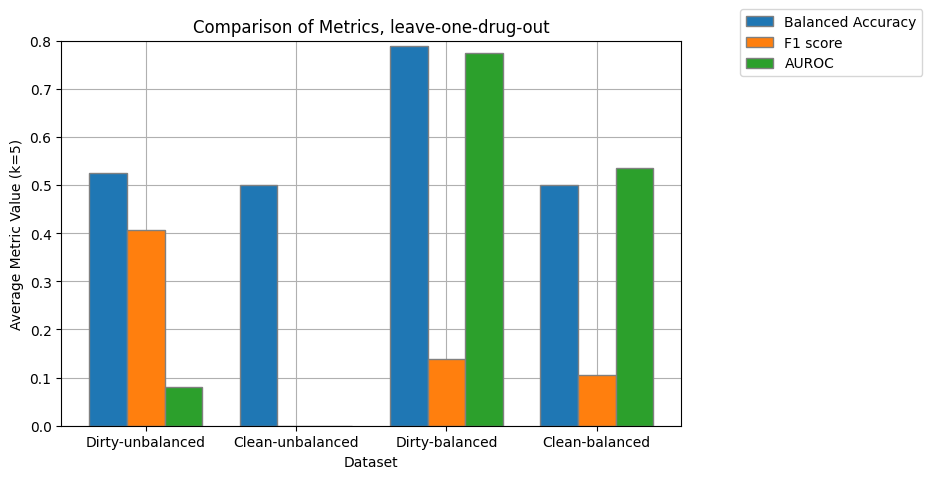

In [ ]:
fig = plt.subplots(figsize =(8, 5))
barWidth = .25

#dirty unbalanced, clean unbalanced, dirty balanced, clean balanced

balanced = [0.5253673956618762, .5, 0.7887872516982017, .4999026997854088]
f1score = [0.4062042124542124,0,0.13794644823411129, 0.10597367390968715]
auroc = [0.08142697466467959, 0, 0.7735294117647059, 0.5353854329253266]

# Set position of bar on X axis
br1 = np.arange(len(balanced))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, balanced,  width = barWidth,
        edgecolor ='grey', label ='Balanced Accuracy')
plt.bar(br2, f1score,  width = barWidth,
        edgecolor ='grey', label ='F1 score')
plt.bar(br3, auroc, width = barWidth,
        edgecolor ='grey', label ='AUROC')

# Adding Xticks
plt.xlabel('Dataset')
plt.ylabel('Average Metric Value (k=5)')
plt.title('Comparison of Metrics, leave-one-drug-out', fontsize = 12)
plt.xticks([r + barWidth for r in range(len(balanced))],
        ['Dirty-unbalanced', 'Clean-unbalanced', 'Dirty-balanced', 'Clean-balanced'])

plt.ylim(0,.8)
plt.rcParams['axes.axisbelow'] = True
plt.grid(zorder = -1)
plt.legend(bbox_to_anchor = (1.4,1.1))
plt.show()

**Discussion and comments:**

Concatenated Morgan fingerprints (each drug has a vector length of 1024, total vector length after concatenation 2048) were used as the input to a random forest model.

K-fold cross-validation showed significant improvement of performance when using the balanced dataset compared to unbalanced (AUROC, balanced accuracy, and F1 score all above 0.75 when averaged across k rounds of validation). This involved a balanced training and balanced validation set. Using unbalanced data, the performance was not significantly better than random (AUROC and balanced accuracy near 0.5). We do not see a noticeable difference between using the cleaned (salts and minor components removed, drug pairs consisting of only salts or minor components removed) and uncleaned (raw) data. This is likely because minor components do not show up in the Morgan fingerprint vector representation.

Leave-one-drug-out involved creating a list of all unique drugs in the dataset, and for each round of validation randomly selecting one drug, taking all pairs containing this drug based on the SMILES representation and separating these to be used as validation, and training on the remaining pairs in the training dataset. Most of the drugs tested here were found in somewhere between 400 and 500 of the pairs in the dataset, leaving over 100,000 for training for each round. The results of this were not promising: using 5 rounds of leave-one-drug-out (different drugs each time), the model over-predicted 0 (no interaction class) for these pairs including drugs it had never seen before. Notably, when we did the cleaned, unbalanced dataset for training, the model did not predict any 1s (all predictions were 0s), leading to a balanced accuracy of 0.5 and AUROC and F1 of 0. This could be randomly that the 5 drugs randomly selected to be left out made up fewer interacting pairs in the data, but generally indicated poor performance of this model/embedding when predicting interactions on "new" drugs. It is possible that if we repeated this process enough that we could look at every drug, we could find one that the model predicts as having a kidney-failure related interaction for some of the pairs more accurately, even for the cleaned unbalanced dataset.

Notably and a distinction between the two validation methods, leave-one-drug-out has a very low balanced accuracy (just above 0.5) for both the unbalanced *and balanced* data, which was very interesting and indicates that both classes could not be predicted accurately. As an experiment (not shown in this notebook), we also tried balancing the dataset before performing leave-one-out validation. Each unique drug was present in fewer pairs, and the model was never able to predict an interaction even when trained on balanced data, more specifically it always predicted 0. This combined with the above results shows that this embedding and model combination is mot particularly good at predicting anything for novel drugs.

###4. Performance of models on testing data

#### 4.1 Clean data (salts and minor components removed)

Full (unbalanced) dataset

In [ ]:
#load in train and test csv files
clean_test_file = "/content/drive/MyDrive/BME 590 Colab files/clean_test_ddi.csv"
clean_train_file = "/content/drive/MyDrive/BME 590 Colab files/clean_train_ddi.csv"

#get smiles and interaction (0 or 1) from the dataframe
df_train_clean = pd.read_csv(clean_train_file)
df_train_clean = df_train_clean.iloc[:, [3, 5, 6]] #get smiles1, smiles2, and interaction classification (1 or 0)

df_test_clean = pd.read_csv(clean_test_file)
df_test_clean = df_test_clean.iloc[:, [3, 5, 6]] #get smiles1, smiles2, and interaction classification (1 or 0)

y_train = df_train_clean.Y
l = len(df_train_clean)
actives_train = np.sum(y_train)

print("Training data length:", l)
print("Number of drug pairs with DDIs",actives_train, "\t",actives_train/l*100, "% of training dataframe")
print("Number of non-DDI drug pairs", l - actives_train, "\t",(l-actives_train)/l*100, "% of training dataframe")

y_test = df_test_clean.Y
l2 = len(df_test_clean)
actives_test = np.sum(y_test)

print("\nTesting data length:", l2)
print("Number of drug pairs with DDIs",actives_test, "\t",actives_test/l2*100, "% of testing dataframe")
print("Number of non-DDI drug pairs", l2 - actives_test, "\t",(l2-actives_test)/l2*100, "% of testing dataframe")

Training data length: 136188
Number of drug pairs with DDIs 14804 	 10.870267571298498 % of training dataframe
Number of non-DDI drug pairs 121384 	 89.1297324287015 % of training dataframe

Testing data length: 34048
Number of drug pairs with DDIs 3659 	 10.746593045112782 % of testing dataframe
Number of non-DDI drug pairs 30389 	 89.25340695488721 % of testing dataframe


In [ ]:
#get fingerprints

fps_train = morgan_concat(df_train_clean)
fps_test = morgan_concat(df_test_clean)

#create balanced dataset for training
undersample = RandomUnderSampler(sampling_strategy='majority') #in majority sampling strategy, will undersmaple the majority class to be the same size as minority. We can play with other methods
fps_train_balanced, y_train_balanced = undersample.fit_resample(fps_train, y_train)

print("Size of balanced dataset from undersampling",len(y_train_balanced))
print("Number of DDI pairs",np.sum(y_train_balanced))

Size of balanced dataset from undersampling 29608
Number of DDI pairs 14804


Balanced training dataset
- train the model on the balanced training dataset, make predictions on unbalanced testing data

In [ ]:
#clean, balanced

#train random forest model
model = RF()
model.fit(fps_train_balanced,y_train_balanced)

#get predictions
y_pred = model.predict(fps_test)
y_prob = model.predict_proba(fps_test)
y_true = y_test

#metrics
print("Accuracy",accuracy_score(y_true, y_pred))
print("Balanced accuracy",balanced_accuracy_score(y_true, y_pred))
print("Precision",precision_score(y_true, y_pred))
print("Recall",recall_score(y_true, y_pred))
print("F1 score",f1_score(y_true, y_pred))
print("AUROC",roc_auc_score(y_true, y_prob[:,1]))

Accuracy 0.7545523966165414
Balanced accuracy 0.777400795304748
Precision 0.2783962264150943
Recall 0.8065045094288057
F1 score 0.41391401921593374
AUROC 0.8544405591301945


Unbalanced training dataset

In [ ]:
#train random forest model
model = RF()
model.fit(fps_train,y_train)

#get predictions
y_pred = model.predict(fps_test)
y_prob = model.predict_proba(fps_test)
y_true = y_test

#metrics
print("Accuracy",accuracy_score(y_true, y_pred))
print("Balanced accuracy",balanced_accuracy_score(y_true, y_pred))
print("Precision",precision_score(y_true, y_pred))
print("Recall",recall_score(y_true, y_pred))
print("F1 score",f1_score(y_true, y_pred))
print("AUROC",roc_auc_score(y_true, y_prob[:,1]))

Accuracy 0.8912711466165414
Balanced accuracy 0.5297021042202424
Precision 0.46083788706739526
Recall 0.06914457502049741
F1 score 0.12024714828897339
AUROC 0.8310225132076468


#### 4.2 Unclean data

In [ ]:
#load in train and test csv files
dirty_test_file = "/content/drive/MyDrive/BME 590 Colab files/dirty_test_ddi.csv"
dirty_train_file = "/content/drive/MyDrive/BME 590 Colab files/dirty_train_ddi.csv"

#get smiles and interaction (0 or 1) from the dataframe
df_train_dirty = pd.read_csv(dirty_train_file)
df_train_dirty = df_train_dirty.iloc[:, [3, 5, 6]] #get smiles1, smiles2, and interaction classification (1 or 0)

df_test_dirty = pd.read_csv(dirty_test_file)
df_test_dirty = df_test_dirty.iloc[:, [3, 5, 6]] #get smiles1, smiles2, and interaction classification (1 or 0)

y_train = df_train_dirty.Y
l = len(df_train_dirty)
actives_train = np.sum(y_train)

print("Training data length:", l)
print("Number of drug pairs with DDIs",actives_train, "\t",actives_train/l*100, "% of training dataframe")
print("Number of non-DDI drug pairs", l - actives_train, "\t",(l-actives_train)/l*100, "% of training dataframe")

y_test = df_test_dirty.Y
l2 = len(df_test_dirty)
actives_test = np.sum(y_test)

print("\nTesting data length:", l2)
print("Number of drug pairs with DDIs",actives_test, "\t",actives_test/l2*100, "% of testing dataframe")
print("Number of non-DDI drug pairs", l2 - actives_test, "\t",(l2-actives_test)/l2*100, "% of testing dataframe")

Training data length: 138532
Number of drug pairs with DDIs 15134 	 10.924551728120578 % of training dataframe
Number of non-DDI drug pairs 123398 	 89.07544827187942 % of training dataframe

Testing data length: 34634
Number of drug pairs with DDIs 3758 	 10.850609227926315 % of testing dataframe
Number of non-DDI drug pairs 30876 	 89.14939077207369 % of testing dataframe


In [ ]:
#get fingerprints

fps_train_dirty = morgan_concat(df_train_dirty)
fps_test_dirty = morgan_concat(df_test_dirty)

#create balanced dataset for training
undersample = RandomUnderSampler(sampling_strategy='majority') #in majority sampling strategy, will undersmaple the majority class to be the same size as minority. We can play with other methods
fps_train_balanced_dirty, y_train_balanced_dirty = undersample.fit_resample(fps_train_dirty, y_train)

print("Size of balanced dataset from undersampling",len(y_train_balanced_dirty))
print("Number of DDI pairs",np.sum(y_train_balanced))

Size of balanced dataset from undersampling 30268
Number of DDI pairs 14804


In [ ]:
#balanced dirty dataset

#train random forest model
model = RF()
model.fit(fps_train_balanced_dirty,y_train_balanced_dirty)

#get predictions
y_pred = model.predict(fps_test_dirty)
y_prob = model.predict_proba(fps_test_dirty)
y_true = y_test

#metrics
print("Accuracy",accuracy_score(y_true, y_pred))
print("Balanced accuracy",balanced_accuracy_score(y_true, y_pred))
print("Precision",precision_score(y_true, y_pred))
print("Recall",recall_score(y_true, y_pred))
print("F1 score",f1_score(y_true, y_pred))
print("AUROC",roc_auc_score(y_true, y_prob[:,1]))

Accuracy 0.7525841658485881
Balanced accuracy 0.7752294780591921
Precision 0.2783970520497467
Recall 0.8041511442256519
F1 score 0.4136043249161705
AUROC 0.8496751818687823


In [ ]:
#unbalanced dirty dataset

#train random forest model
model = RF()
model.fit(fps_train_dirty,y_train)

#get predictions
y_pred = model.predict(fps_test_dirty)
y_prob = model.predict_proba(fps_test_dirty)
y_true = y_test

#metrics
print("Accuracy",accuracy_score(y_true, y_pred))
print("Balanced accuracy",balanced_accuracy_score(y_true, y_pred))
print("Precision",precision_score(y_true, y_pred))
print("Recall",recall_score(y_true, y_pred))
print("F1 score",f1_score(y_true, y_pred))
print("AUROC",roc_auc_score(y_true, y_prob[:,1]))

Accuracy 0.8901657330946469
Balanced accuracy 0.5309229760119294
Precision 0.4608843537414966
Recall 0.07211282597126131
F1 score 0.1247123791992637
AUROC 0.8288572451491143


####4.3 Graph and analysis

See short discussion below graph

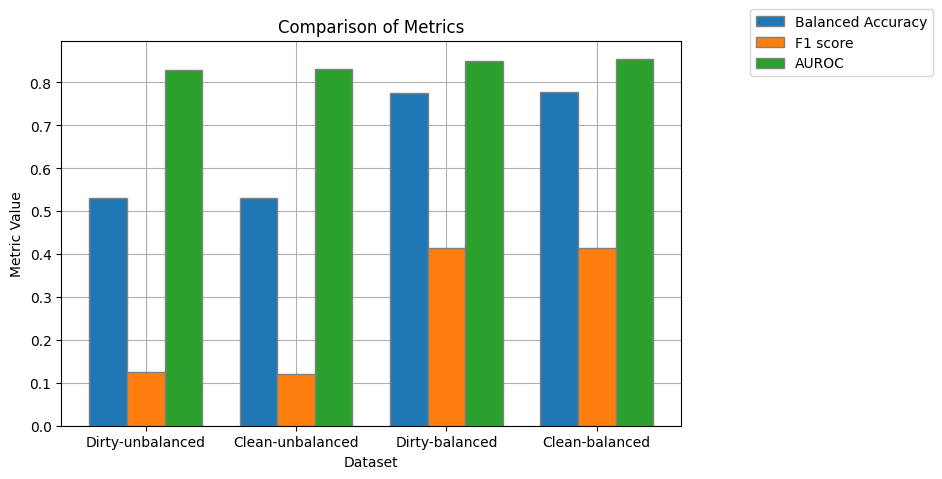

In [ ]:
fig = plt.subplots(figsize =(8, 5))
barWidth = .25

#dirty unbalanced, clean unbalanced, dirty balanced, clean balanced

balanced = [0.5309229760119294, 0.5297021042202424, 0.7752294780591921, 0.777400795304748]
f1score = [0.1247123791992637, 0.12024714828897339, 0.4136043249161705, 0.41391401921593374]
auroc = [0.8288572451491143, .8310225132076468, 0.8496751818687823, 0.8544405591301945]

# Set position of bar on X axis
br1 = np.arange(len(balanced))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, balanced,  width = barWidth,
        edgecolor ='grey', label ='Balanced Accuracy')
plt.bar(br2, f1score,  width = barWidth,
        edgecolor ='grey', label ='F1 score')
plt.bar(br3, auroc, width = barWidth,
        edgecolor ='grey', label ='AUROC')

# Adding Xticks
plt.xlabel('Dataset')
plt.ylabel('Metric Value')
plt.title('Comparison of Metrics', fontsize = 12)
plt.xticks([r + barWidth for r in range(len(balanced))],
        ['Dirty-unbalanced', 'Clean-unbalanced', 'Dirty-balanced', 'Clean-balanced'])


plt.rcParams['axes.axisbelow'] = True
plt.grid(zorder = -2)
plt.legend(bbox_to_anchor = (1.1, 1.1))
plt.show()

**Discussion and comments**

Random forest model with concatenated Morgan fingerprint vectors as inputs, assessed on testing data:

To assess model performance on the testing set, we tried our four different variations of the training set: using either cleaned or uncleaned drug representations, and using either unbalanced (full training dataset) or balanced (random undersampling of majority class) data. The testing data was cleaned but not modified (ie balanced), as we do not expect that experimentally or clinically obtained data about drug pairs will be balanced. We observed not much better than random performance when using the unbalanced training data, and significantly improved performace (AUROC and balanced accuracy above 0.75, F1 score above 0.4) using balanced training data.